In [1]:
import random
import copy
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.colors as colors
import os
import subprocess

In [14]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix"
})

The function below computes the energy $E$ of $N$ atoms.The energy $E$ of the atoms is the sum of all
  pairwise energies given by
  \begin{equation*}
    E = 4 \sum\limits_{i=1}^N \sum\limits_{j=i+1}^N \left(
    \frac{1}{r_{ij}^{12}} - \frac{1}{r_{ij}^6} \right),
  \end{equation*}
  where $r_{ij}$ is the distance between atom $i$ and atom $j$.

In [66]:
a1 = 2.46 * np.array([1, 0])
a2 = 2.46 * np.array([1 / 2, np.sqrt(3) / 2])
cc = (a1 + a2) / 3

In [2]:
def angles(N):
    return np.round(
        np.arccos(
            ((N - 1) ** 2 + 4 * N * (N - 1) + N ** 2) / (2 * ((N - 1) ** 2 + N * (N - 1) + N ** 2))
        ) * 180 / np.pi, 
        10
    )

def num_atoms(N):
    return int(np.round(1 / np.square(np.sin(np.pi / 180 * angles(N) / 2)), 0))

N = 5
structure = np.loadtxt(f"N_{N}/DFT-structures/structure.fdf", skiprows=17, usecols=[0, 1, 2], max_rows=num_atoms(N))
structure[:, 2] -= structure[0, 2]
structure[len(structure) // 2:, 2] += 0.0

In [3]:
neighbors = [[] for _ in range(len(structure))]
for i, atom_i in enumerate(structure):
    for j, atom_j in enumerate(structure):
        if i == j:
            continue
        # print(np.linalg.norm(atom_i - atom_j))
        if np.linalg.norm(atom_i - atom_j) < 1.43:
            neighbors[i].append(j)

In [4]:
def fun_no_twist(x_z_only):
    all_pos = []
    E = 0
    for idx, xi in enumerate(x_z_only):
        for i in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
            for j in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
                for c in [0, 1]:
                    pos = [np.array([c * cc[0] + i * a1[0] + j * a2[0], c * cc[1] + i * a1[1] + j * a2[1], xi])]
                    # if idx == 1:
                    #     pos = [np.array([pos[0][0] + cc[0], pos[0][1] + cc[1], pos[0][2]])]
                    all_pos += pos
    # all_pos = ([0, 0, x2] + [cc[0], cc[1], x2] + [a1[0], a1[1], x2] + [a1[0] + cc[0], a1[1] + cc[1], x2] + [a2[0], a2[1], x2] + [a2[0] + cc[0], a2[1] + cc[1], x2] + 
    #            [0, 0, x1] + [cc[0], cc[1], x1] + [a1[0], a1[1], x1] + [a1[0] + cc[0], a1[1] + cc[1], x1] + [a2[0], a2[1], x1] + [a2[0] + cc[0], a2[1] + cc[1], x1]
    #           ) 
    # all_pos = ([0, x2] + [np.linalg.norm(cc), x2] + #[a1[0], a1[1], x2] + [a1[0] + cc[0], a1[1] + cc[1], x2] + [a2[0], a2[1], x2] + [a2[0] + cc[0], a2[1] + cc[1], x2] + 
    #            [0, x1] + [np.linalg.norm(cc), x1] #+ [a1[0], a1[1], x1] + [a1[0] + cc[0], a1[1] + cc[1], x1] + [a2[0], a2[1], x1] + [a2[0] + cc[0], a2[1] + cc[1], x1]
    #           )
    # print(all_pos)
    for i, pos_i in enumerate(all_pos[:len(all_pos) // 2]):
        for j, pos_j in enumerate(all_pos[len(all_pos) // 2:]):
            r2 = np.linalg.norm(pos_i - pos_j) ** 2
            # print(r2)
            # assert False
            r2inv = 3.4 ** 2 / (r2 + 1e-16)  # 3.4 for graphene
            r6inv = r2inv * r2inv * r2inv
            r12inv = r6inv * r6inv
            E += r12inv - r6inv
            # print("E:", E)
    return 4 * E

def pso_no_twist(fun, lo, hi, nstep, S=None, K=None):
    D = len(lo)  # Number of degrees of freedom
    if S is None:
        S = 10 + int(2 * math.sqrt(D))
    if K is not None:
        links = get_links(S, K)

    # x is a list of shape (S, size), where S is the number of particles and 
    # each particle is a configuration of D (size) atomic positions. Same for v,
    # but v is a velocity
    x = [[(random.uniform(lo, hi)) for lo, hi in zip(lo, hi)] for i in range(S)]  # Randomly initialize positions. MUST CHANGE
    v = [[(random.uniform(lo, hi) - x) / 2 for x, lo, hi in zip(x[i], lo, hi)]  # Randomly initialize velocities
         for i in range(S)]
    p = copy.deepcopy(x)

    # score is a list of length S containing the energy for each particle (configuration)
    score = [fun(x) for x in x]

    # globally optimal score (energy) and positions found so far
    best_idx = np.argmin(score)
    sg, pg = score[best_idx], p[best_idx]
    print(sg)
    # print(pg)
    w = 0.9
    c = 1
    istep = 0
    while True:
        if istep >= nstep:
            break
        for i in range(S):

            # If neighbor parameter isn't specified, all particles are neighbors of each other
            if K is None:
                ph = pg
            else:
                best_h_idx = np.argmin([score[j]] for j in links[i])
                sh, ph = score[best_h_idx], p[best_h_idx]
            for d in range(D):

                # PSO update step
                v[i][d] = (w - (w - 0.4) * istep / nstep) * v[i][d] + random.uniform(0, 
                        c / 1) * (ph[d] - x[i][d]) + random.uniform(
                        0, c) * (p[i][d] - x[i][d])
                x[i][d] += v[i][d]

                # Don't let the coordinates go out of bounds
                if x[i][d] < lo[d]:
                    x[i][d] = lo[d]
                    v[i][d] = 0
                if x[i][d] > hi[d]:
                    x[i][d] = hi[d]
                    v[i][d] = 0
        Improved = False
        for i in range(S):
            s = fun(x[i])

            # If new score is better than current score for this particle, replace the score (and replace the particle's positions too)
            if s < score[i]:
                score[i] = s
                p[i] = x[i][:]

                # If new score is better than the globally optimal score, replace (and replace the globally optimal position)
                if s < sg:
                    sg = s
                    pg = x[i][:]
                    Improved = True

        # If the global score didn't improve and we want specific neighbors, let's find some new neighbors
        if K is not None and not Improved:
            links = get_links(S, K)
        istep += 1
        print(sg)
    return sg, pg

In [5]:
#Implementation of the Particle Swarm Optimization.
#fun = function that is minimize
#lo, hi = lower and upper limits of the domain
#nstep = number of steps
#S = Swarm size
#K = maximum number of particles informed by a given one

#There are other parameters defined directly in the code which can/should be modified too.

#Helper-Function to establish the links
def get_links(S, K):
    links = [set([i]) for i in range(S)]  # Each particle is initialized with itself as a neighbor
    for i in range(S):
        for j in range(K):
            k = random.randrange(S)  # Currently, the code adds each particle i as a neighbor to K other random particles. There may be duplicates. MUST CHANGE
            links[k].add(i)
    return links

def fun(x_z_only, struct): 
    x = [np.array([struct[i, 0], struct[i, 1], z]) for i, z in enumerate(x_z_only)]
    # print(len(x))
    E = 0

    for i, pos_i in enumerate(x):
        for neighbor in neighbors[i]:
            E += 0.5 * 300000 * (1.420281662 - np.linalg.norm(x[neighbor] - pos_i)) ** 2
    
    for i, pos_i in enumerate(x[:len(x) // 2]):
        for j, pos_j in enumerate(x[len(x) // 2:]):
            r2 = np.linalg.norm(pos_i - pos_j) ** 2
            # print(r2)
            # assert False
            r2inv = 3.4 ** 2 / (r2 + 1e-16)  # 3.4 for graphene
            r6inv = r2inv * r2inv * r2inv
            r12inv = r6inv * r6inv
            E += r12inv - r6inv
    return 4 * E
    # for i in range(0, N, 3):
    #     for j in range(i + 3, N, 3):  # There are no self-interactions
    #         ix, iy, iz = i, i + 1, i + 2
    #         jx, jy, jz = j, j + 1, j + 2
    #         dx = x[ix] - x[jx]
    #         dy = x[iy] - x[jy]
    #         # print(x[iz], x[jz])
    #         dz = x[iz] - x[jz]
    #         r2 = dx * dx + dy * dy + dz * dz
    #         r2inv = 3.4 ** 2 / (r2 + 1e-16)  # 3.4 for C-C bond in graphene
    #         r6inv = r2inv * r2inv * r2inv
    #         r12inv = r6inv * r6inv
    #         E += r12inv - r6inv
    # return 4 * E

def pso_twist(fun, lo, hi, nstep, initial_structure, S=None, K=None):
    D = len(lo)  # Number of degrees of freedom
    if S is None:
        S = 10 + int(2 * math.sqrt(D))
    if K is not None:
        links = get_links(S, K)

    # x is a list of shape (S, size), where S is the number of particles and 
    # each particle is a configuration of D (size) atomic positions. Same for v,
    # but v is a velocity
    x = []
    for i in range(S):
        x.append(initial_structure[:, 2])
    # x = [initial_structure[:, 2] for i in range(S)]  # Randomly initialize positions. MUST CHANGE
    v = [[-(random.uniform(0, np.amax(x)) - x_i) / 200 for x_i, lo, hi in zip(x[i], lo, hi)]  # Randomly initialize velocities
         for i in range(S)]
    p = copy.deepcopy(x)

    # score is a list of length S containing the energy for each particle (configuration)
    score = [fun(x, initial_structure) for x in x]
    # print(x)

    # globally optimal score (energy) and positions found so far
    best_idx = np.argmin(score)
    sg, pg = score[best_idx], p[best_idx]
    print(sg)
    # print(pg)
    w = 0.9
    c = 1
    istep = 0
    while True:
        if istep >= nstep:
            break
        for i in range(S):

            # If neighbor parameter isn't specified, all particles are neighbors of each other
            if K is None:
                ph = pg
            else:
                best_h_idx = np.argmin([score[j]] for j in links[i])
                sh, ph = score[best_h_idx], p[best_h_idx]
            for d in range(D):

                # PSO update step
                # TODOOOOOOOOO: Maybe use different signed velocities for the bottom and top layer?
                v[i][d] = (w - (w - 0.4) * istep / nstep) * v[i][d] + random.uniform(0, 
                        c / 10) * (ph[d] - x[i][d]) + random.uniform(
                        0, c) * (p[i][d] - x[i][d])
                x[i][d] += v[i][d]

                # Don't let the coordinates go out of bounds
                if x[i][d] < lo[d]:
                    x[i][d] = lo[d]
                    v[i][d] = 0
                if x[i][d] > hi[d]:
                    x[i][d] = hi[d]
                    v[i][d] = 0
        Improved = False
        for i in range(S):
            s = fun(x[i], initial_structure)

            # If new score is better than current score for this particle, replace the score (and replace the particle's positions too)
            if s < score[i]:
                # print("hi")
                score[i] = s
                p[i] = x[i][:]

                # If new score is better than the globally optimal score, replace (and replace the globally optimal position)
                if s < sg:
                    sg = s
                    pg = x[i][:]
                    Improved = True

        # If the global score didn't improve and we want specific neighbors, let's find some new neighbors
        if K is not None and not Improved:
            links = get_links(S, K)
        istep += 1
        print(sg)
        # print(pg)
    return sg, pg


In [6]:
#Implementation of the Particle Swarm Optimization.
#fun = function that is minimize
#lo, hi = lower and upper limits of the domain
#nstep = number of steps
#S = Swarm size
#K = maximum number of particles informed by a given one

#There are other parameters defined directly in the code which can/should be modified too.

#Helper-Function to establish the links
def get_links(S, K):
    links = [set([i]) for i in range(S)]  # Each particle is initialized with itself as a neighbor
    for i in range(S):
        for j in range(K):
            k = random.randrange(S)  # Currently, the code adds each particle i as a neighbor to K other random particles. There may be duplicates. MUST CHANGE
            links[k].add(i)
    return links

def fun_z_only(x_z_only, struct): 
    x = []
    for i in range(len(struct) // 2):
        x.append(np.array([struct[i, 0], struct[i, 1], x_z_only[0]]))
    for i in range(len(struct) // 2, len(struct)):
        x.append(np.array([struct[i, 0], struct[i, 1], x_z_only[1]]))
    # print(len(x))
    E = 0

    # for i, pos_i in enumerate(x):
    #     for neighbor in neighbors[i]:
    #         E += 0.5 * 300000 * (1.420281662 - np.linalg.norm(x[neighbor] - pos_i)) ** 2
    
    for i, pos_i in enumerate(x[:len(x) // 2]):
        for j, pos_j in enumerate(x[len(x) // 2:]):
            r2 = np.linalg.norm(pos_i - pos_j) ** 2
            # print(r2)
            # assert False
            r2inv = 3.4 ** 2 / (r2 + 1e-16)  # 3.4 for graphene
            r6inv = r2inv * r2inv * r2inv
            r12inv = r6inv * r6inv
            E += r12inv - r6inv
    return 4 * E
    # for i in range(0, N, 3):
    #     for j in range(i + 3, N, 3):  # There are no self-interactions
    #         ix, iy, iz = i, i + 1, i + 2
    #         jx, jy, jz = j, j + 1, j + 2
    #         dx = x[ix] - x[jx]
    #         dy = x[iy] - x[jy]
    #         # print(x[iz], x[jz])
    #         dz = x[iz] - x[jz]
    #         r2 = dx * dx + dy * dy + dz * dz
    #         r2inv = 3.4 ** 2 / (r2 + 1e-16)  # 3.4 for C-C bond in graphene
    #         r6inv = r2inv * r2inv * r2inv
    #         r12inv = r6inv * r6inv
    #         E += r12inv - r6inv
    # return 4 * E

def pso_twist_z_only(fun, lo, hi, nstep, initial_structure, S=None, K=None):
    D = len(lo)  # Number of degrees of freedom
    if S is None:
        S = 10 + int(2 * math.sqrt(D))
    if K is not None:
        links = get_links(S, K)

    # x is a list of shape (S, size), where S is the number of particles and 
    # each particle is a configuration of D (size) atomic positions. Same for v,
    # but v is a velocity
    x = [[initial_structure[0, 2], initial_structure[-1, 2]] for i in range(S)]
    # for i in range(S):
    #     x.append(initial_structure[:, 2])
    # x = [initial_structure[:, 2] for i in range(S)]  # Randomly initialize positions. MUST CHANGE
    v = [[-(random.uniform(0, np.amax(x)) - x_i) / 200 for x_i, lo, hi in zip(x[i], lo, hi)]  # Randomly initialize velocities
     for i in range(S)]
    p = copy.deepcopy(x)

    # score is a list of length S containing the energy for each particle (configuration)
    score = [fun(x, initial_structure) for x in x]
    # print(x)

    # globally optimal score (energy) and positions found so far
    best_idx = np.argmin(score)
    sg, pg = score[best_idx], p[best_idx]
    print(sg)
    # print(pg)
    w = 1
    c = 1
    istep = 0
    while True:
        if istep >= nstep:
            break
        for i in range(S):

            # If neighbor parameter isn't specified, all particles are neighbors of each other
            if K is None:
                ph = pg
            else:
                best_h_idx = np.argmin([score[j]] for j in links[i])
                sh, ph = score[best_h_idx], p[best_h_idx]
            for d in range(D):

                # PSO update step
                # TODOOOOOOOOO: Maybe use different signed velocities for the bottom and top layer?
                v[i][d] = 2 * (w * 0.5 ** istep) * v[i][d] + random.uniform(0, 
                        c / 1) * (ph[d] - x[i][d]) + random.uniform(
                        0, c) * (p[i][d] - x[i][d])
                # v[i][d] = 3 * w * v[i][d] + random.uniform(0, 
                #         c / 1) * (ph[d] - x[i][d]) + random.uniform(
                #         0, c) * (p[i][d] - x[i][d])
                x[i][d] += v[i][d]

                # Don't let the coordinates go out of bounds
                if x[i][d] < lo[d]:
                    x[i][d] = lo[d]
                    v[i][d] = 0
                if x[i][d] > hi[d]:
                    x[i][d] = hi[d]
                    v[i][d] = 0
        Improved = False
        for i in range(S):
            s = fun(x[i], initial_structure)

            # If new score is better than current score for this particle, replace the score (and replace the particle's positions too)
            if s < score[i]:
                # print("hi")
                score[i] = s
                p[i] = x[i][:]

                # If new score is better than the globally optimal score, replace (and replace the globally optimal position)
                if s < sg:
                    sg = s
                    pg = x[i][:]
                    Improved = True

        # If the global score didn't improve and we want specific neighbors, let's find some new neighbors
        if K is not None and not Improved:
            links = get_links(S, K)
        istep += 1
        print(sg)
        # print(pg)
    return sg, pg

Please feel free to change the PSO implementation and all parameters in order to find the lowest possible energy value !

In [140]:
#Run the optimisation and print the obtained energy value
random.seed(123456)    #Fix a seed
n = num_atoms(N)   #Dimension (fixed). This is basically the number of atoms
low = -4   # This is the bounds for the atoms' positions
high = 4
size = 2   # This is the number of degrees of freedom. We subtract 6 because the code fixes 6 atomic coordinates to 0 (see unpack())

# Usage: 
# objective function, 
# lower position bound for each degree of freedom, 
# upper position bound for each degree of freedom, 
# nstep: num steps, 
# K: kind of controls the number of neighbors. It is the number of times that any particle can be a neighbor of another (see get_links)
# S: number of particles (swarm size). If None, set to 10 + 2*sqrt(number of degrees of freedom)
E, x = pso_no_twist(fun_no_twist, [low] * size, [high] * size, 10, K=None, S=10)
print("%.8f" % E)

-1746.524676968612
-1901.1858068668337
-2093.676375688763
-2093.676375688763
-2093.676375688763
-2093.676375688763
-2093.676375688763
-2106.570011729602
-2106.570011729602
-2107.6326798261603
-2107.6326798261603
-2107.63267983


In [107]:
x

[-3.893008299618767, -0.4744161472387125]

In [115]:
x[1] - x[0]

3.449752753415436

In [8]:
s10ab = np.array([
-1731.7883587689612,
-1889.3921279836195,
-2128.5294149924016,
-2128.5294149924016,
-2128.5294149924016,
-2128.5294149924016,
-2128.5294149924016,
-2128.5294149924016,
-2128.5294149924016,
-2129.7355920435975,
-2129.7355920435975
]) * 2.96 / 4

s50ab = np.array([
-2129.69397437797,
-2129.69397437797,
-2129.69397437797,
-2129.69397437797,
-2129.833732780434,
-2131.359576281005,
-2131.359576281005,
-2131.359576281005,
-2131.8431419780572,
-2131.8431419780572,
-2131.8431419780572
]) * 2.96 / 4

s100ab = np.array([
-2129.69397437797,
-2131.035218959756,
-2131.7907345531753,
-2131.7907345531753,
-2131.8431195327357,
-2131.8431195327357,
-2131.8431195327357,
-2131.8431195327357,
-2131.8431195327357,
-2131.8431195327357,
-2131.8431195327357,
]) * 2.96 / 4

s10aa = np.array([
-1746.524676968612,
-1901.1858068668337,
-2093.676375688763,
-2093.676375688763,
-2093.676375688763,
-2093.676375688763,
-2093.676375688763,
-2106.570011729602,
-2106.570011729602,
-2107.6326798261603,
-2107.6326798261603
]) * 2.96 / 4

s50aa = np.array([
-2108.8898536471706,
-2108.8898536471706,
-2108.8898536471706,
-2108.8898536471706,
-2108.8898536471706,
-2108.8898536471706,
-2108.8898536471706,
-2109.076893035683,
-2109.077840806797,
-2109.077840806797,
-2109.077840806797
]) * 2.96 / 4

s100aa = np.array([
-2108.8898536471706,
-2108.8898536471706,
-2108.9135122323537,
-2108.9135122323537,
-2109.036297398399,
-2109.0773290441334,
-2109.0773290441334,
-2109.0773290441334,
-2109.0773290441334,
-2109.078489295218,
-2109.078489295218
]) * 2.96 / 4

In [9]:
np.array(s10ab) + min(s100ab)

array([-2859.08729394, -2975.71408316, -3152.67567555, -3152.67567555,
       -3152.67567555, -3152.67567555, -3152.67567555, -3152.67567555,
       -3152.67567555, -3153.56824657, -3153.56824657])

In [10]:
plt.rcParams.update({
    "font.family": "DeJavu Serif",
    "font.serif": "Times New Roman",
    "mathtext.fontset": "stix"
})

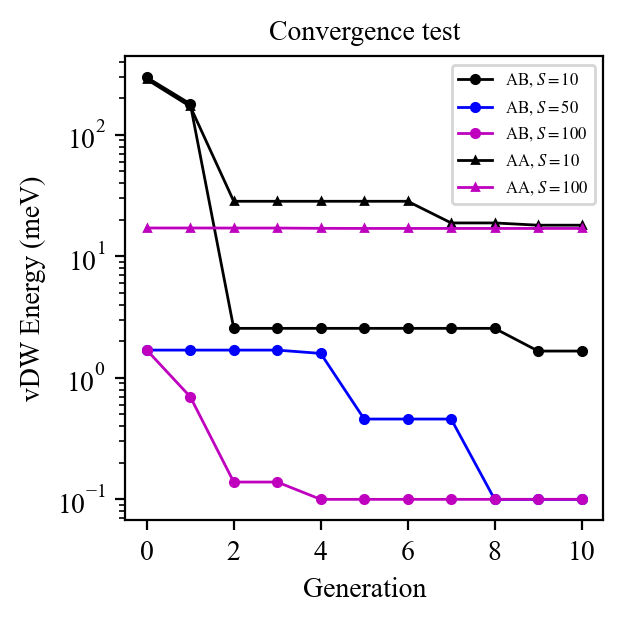

In [45]:
f, ax = plt.subplots(1, 1, dpi=200, figsize=(3, 3), layout="constrained")
ax.plot(np.array(s10ab) - min(s100ab) + 1e-1, marker=".", lw=1, color="k", label=r"AB, $S=10$")
ax.plot(np.array(s50ab) - min(s100ab) + 1e-1, marker=".", lw=1, color="b", label=r"AB, $S=50$")
ax.plot(np.array(s100ab) - min(s100ab) + 1e-1, marker=".", lw=1, color="m", label=r"AB, $S=100$")
ax.plot(np.array(s10aa) - min(s100ab) + 1e-1, marker="^", markersize=2, lw=1, color="k", label=r"AA, $S=10$")
# ax.plot(np.array(s50aa) - min(s100ab) + 1e-1)
ax.plot(np.array(s100aa) - min(s100ab) + 1e-1, marker="^", markersize=2, lw=1, color="m", label=r"AA, $S=100$")
ax.set_yscale("log")
ax.set_ylabel(r"vDW Energy (meV)")
ax.set_xlabel("Generation")
ax.set_title("Convergence test", fontsize=10)
ax.set_xticks(np.arange(0, 11, 2),np.arange(0, 11, 2))
ax.legend(fontsize=6)
plt.savefig("convergence-test.png", bbox_inches="tight", dpi=200)

AB:

S = 10
-1731.7883587689612
-1889.3921279836195
-2128.5294149924016
-2128.5294149924016
-2128.5294149924016
-2128.5294149924016
-2128.5294149924016
-2128.5294149924016
-2128.5294149924016
-2129.7355920435975
-2129.7355920435975

-1746.524676968612
-1901.1858068668337
-2093.676375688763
-2093.676375688763
-2093.676375688763
-2093.676375688763
-2093.676375688763
-2106.570011729602
-2106.570011729602
-2107.6326798261603
-2107.6326798261603

S = 50
-2129.69397437797
-2129.69397437797
-2129.69397437797
-2129.69397437797
-2129.833732780434
-2131.359576281005
-2131.359576281005
-2131.359576281005
-2131.8431419780572
-2131.8431419780572
-2131.8431419780572

-2108.8898536471706
-2108.8898536471706
-2108.8898536471706
-2108.8898536471706
-2108.8898536471706
-2108.8898536471706
-2108.8898536471706
-2109.076893035683
-2109.077840806797
-2109.077840806797
-2109.077840806797

S = 100
-2129.69397437797
-2131.035218959756
-2131.7907345531753
-2131.7907345531753
-2131.8431195327357
-2131.8431195327357
-2131.8431195327357
-2131.8431195327357
-2131.8431195327357
-2131.8431195327357
-2131.8431195327357

-2108.8898536471706
-2108.8898536471706
-2108.9135122323537
-2108.9135122323537
-2109.036297398399
-2109.0773290441334
-2109.0773290441334
-2109.0773290441334
-2109.0773290441334
-2109.078489295218
-2109.078489295218

In [ ]:
#Run the optimisation and print the obtained energy value
random.seed(123456)    #Fix a seed
n = num_atoms(N)   #Dimension (fixed). This is basically the number of atoms
low = -4   # This is the bounds for the atoms' positions
high = 4
size = 2   # This is the number of degrees of freedom. We subtract 6 because the code fixes 6 atomic coordinates to 0 (see unpack())

# Usage: 
# objective function, 
# lower position bound for each degree of freedom, 
# upper position bound for each degree of freedom, 
# nstep: num steps, 
# K: kind of controls the number of neighbors. It is the number of times that any particle can be a neighbor of another (see get_links)
# S: number of particles (swarm size). If None, set to 10 + 2*sqrt(number of degrees of freedom)
E, x = pso_twist_z_only(fun_z_only, [low] * size, [high] * size, 5, structure, K=None, S=100)
print("%.8f" % E)

In [46]:
#Run the optimisation and print the obtained energy value
random.seed(123456)    #Fix a seed
n = num_atoms(N)   #Dimension (fixed). This is basically the number of atoms
low = -4   # This is the bounds for the atoms' positions
high = 4
size = num_atoms(N)   # This is the number of degrees of freedom. We subtract 6 because the code fixes 6 atomic coordinates to 0 (see unpack())

# Usage: 
# objective function, 
# lower position bound for each degree of freedom, 
# upper position bound for each degree of freedom, 
# nstep: num steps, 
# K: kind of controls the number of neighbors. It is the number of times that any particle can be a neighbor of another (see get_links)
# S: number of particles (swarm size). If None, set to 10 + 2*sqrt(number of degrees of freedom)
E, x = pso_twist(fun, [low] * size, [high] * size, 5, structure, K=None, S=100)
print("%.8f" % E)

-1523.8973015211054
-1532.5635930221774
-1532.5635930221774
-1532.5635930221774
-1532.5635930221774
-1532.5635930221774
-1532.56359302


# PSO z only

- 4:

- 5: -1532.56359302

-1523.8973015211054

-1532.5635930221774

-1532.5635930221774

-1532.5635930221774

-1532.5635930221774

-1532.5635930221774

- 6: -2409.50718038

-2395.8742943361026

-2409.5071803801266

-2409.5071803801266

-2409.5071803801266

-2409.5071803801266

-2409.5071803801266

- 7: -3483.04785292

-3466.2816068755183

-3483.047852916399

-3483.047852916399

-3483.047852916399

-3483.047852916399

-3483.047852916399

- 8: -4756.97841740

-4735.190262009995

-4756.978417404626

-4756.978417404626

-4756.978417404626

-4756.978417404626

-4756.978417404626

- 9: -6231.40087197

-6202.63894179265

-6231.400871967862

-6231.400871967862

-6231.400871967862

-6231.400871967862

# PSO 2params

- 4: -862.39337692

-850.21749758358

-861.8538272133134

-862.3933505576183

-862.3933683186825

-862.3933683186825

-862.3933768276181

-862.3933768276181

-862.3933768874526

-862.3933769191292

-862.3933769221137

-862.3933769241647

- 5: -1541.52486669

-1523.8973015211225

-1541.1813646712071

-1541.5240007712703

-1541.5241323533637

-1541.5248606259756

-1541.5248666833968

-1541.5248666833968

-1541.5248666833968

-1541.5248666833968

-1541.5248666912105

-1541.5248666913344

- 6: -2419.87715495

-2395.8742943361285

-2419.693683160233

-2419.8758286230695

-2419.8758286230695

-2419.8770377048786

-2419.8771535289966

-2419.8771539384084

-2419.8771539384084

-2419.8771549544563

-2419.8771549544563

-2419.8771549544563

- 7: -3497.59056611

-3466.2816068755556

-3497.520084428303

-3497.5894123402954

-3497.5895267454916

-3497.590386170494

-3497.5905659371238

-3497.5905659371238

-3497.5905659371238

-3497.5905659371238

-3497.590566106224

-3497.590566106224

- 8: -4774.73939543

-4735.190262010046

-4774.729492315559

-4774.730832614181

-4774.739351143328

-4774.739387853083

-4774.739387853083

-4774.739387853083

-4774.739395209125

-4774.739395209125

-4774.739395429971

-4774.739395429971

- 9: -6251.36676316

-6202.641634398901

-6251.362070297963

-6251.366747916526

-6251.366747916526

-6251.366747916526

-6251.366747916526

-6251.3667626728375

-6251.3667626728375

-6251.366763163588

-6251.366763163588

-6251.366763164034

- 10: -7927.49940240

-7868.661429681327

-7927.442784590921

-7927.499198347879

-7927.499198347879

-7927.499372175134

-7927.49938138128

-7927.49938138128

-7927.499402272409

-7927.499402272409

-7927.4994023439995

-7927.499402400321

- 11: -9803.15475496

-9733.266441647707

-9803.116662265895

-9803.154585620709

-9803.154585620709

-9803.154585620709

-9803.15475459631

-9803.15475459631

-9803.15475459631

-9803.15475489484

-9803.15475489484

-9803.154754956578

- 12: -11878.34467694

In [88]:
x

[np.float64(-0.03943301327702719), np.float64(3.3773803118039947)]

In [22]:
# x

In [23]:
np.abs(x[0] - x[1])

0.0023961392299179374

AA: 3.46 A
AB: 3.42 A

In [234]:
relaxed_structure = np.loadtxt(f"tblg-dft-extrapolations/N_{N}/relaxation-comparison/Graphene.XV", skiprows=4, usecols=[2, 3, 4]) * 0.529177249

In [235]:
relaxed_structure[:len(relaxed_structure) // 2, 2] += 0.09
fun(relaxed_structure[:, 2], relaxed_structure)

-1537.609190808301

In [97]:
x = np.repeat(x, len(structure) // 2)

Text(0.5, 1.0, 'Interlayer relaxation, $\\theta=7.34$')

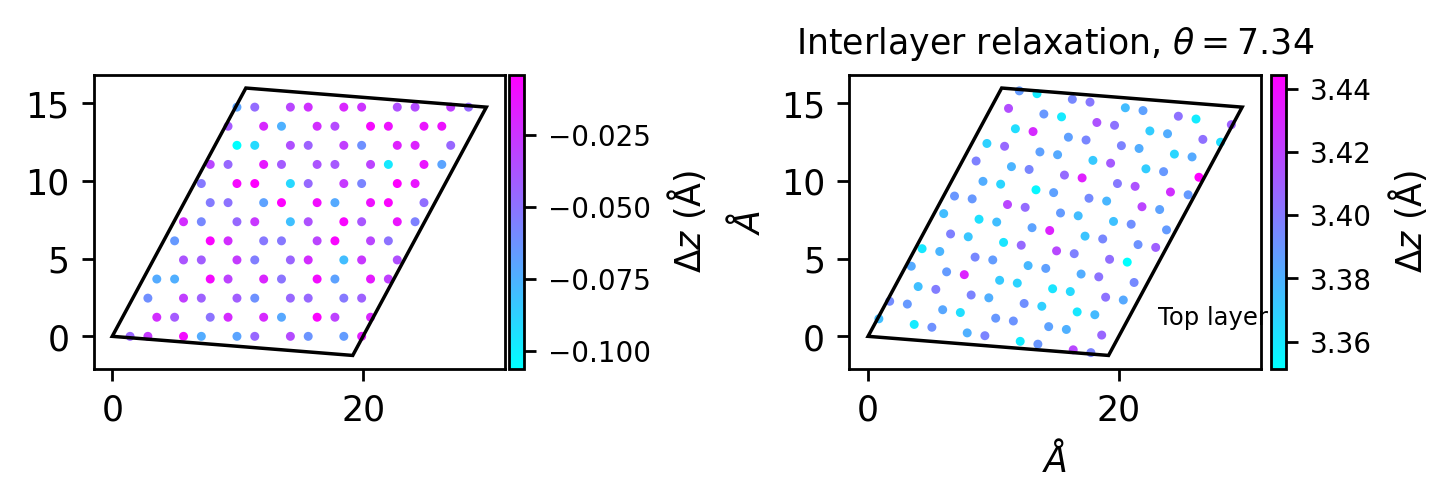

In [47]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(5.7, 1.9), dpi=250, layout='constrained')
cmap = plt.cm.cool
# norm = colors.Normalize(
#     vmin=min(
#         np.amin(siesta_r[len(siesta_r) // 2:, 2] - siesta_u[len(siesta_u) // 2:, 2]),
#         np.amin(siesta_u[:len(siesta_u) // 2, 2] - siesta_r[:len(siesta_r) // 2, 2]),
#     ), 
#     vmax=max(
#         np.amax(siesta_r[len(siesta_r) // 2:, 2] - siesta_u[len(siesta_u) // 2:, 2]),
#         np.amax(siesta_u[:len(siesta_u) // 2, 2] - siesta_r[:len(siesta_r) // 2, 2]),
#     ), 
# )

# origin = siesta_u[len(siesta_u) // 2:, :2]
# z = siesta_u[len(siesta_u) // 2:, 2]
# arrow = siesta_r[len(siesta_r) // 2:, 2] - z
p3 = axes[0].scatter(structure[:len(structure) // 2, 0], structure[:len(structure) // 2, 1], c=x[:len(x) // 2], cmap=cmap, s=2.5)
# axes[0].annotate("Top", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
# N = 5
lattice_vec = np.loadtxt(f"N_{N}/DFT-structures/structure.fdf", skiprows=2, usecols=[0, 1, 2], max_rows=2)
a = lattice_vec[0][:2]
b = lattice_vec[1][:2]
points = [[0, 0], a, a + b, b]
axes[0].add_patch(patches.Polygon(points, fill=False))
# axes[0].set_title("Siesta", fontsize=11)

cbar = f.colorbar(
    p3, 
    ax=axes[0], 
    label=r"$\Delta z$ $(\mathrm{\AA})$",
    pad=0.01
    # ticks=[0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
)
cbar.ax.tick_params(labelsize=8)

# origin = siesta_u[:len(siesta_u) // 2, :2]
# z = siesta_u[:len(siesta_u) // 2, 2]
# arrow = z - siesta_r[:len(siesta_r) // 2, 2]
p4 = axes[1].scatter(structure[len(structure) // 2:, 0], structure[len(structure) // 2:, 1], c=x[len(x) // 2:], cmap=cmap, s=2.5)
axes[1].annotate("Top layer", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=7, color="k")
# Parallelogram
a = lattice_vec[0][:2]
b = lattice_vec[1][:2]
points = [[0, 0], a, a + b, b]
axes[1].add_patch(patches.Polygon(points, fill=False))
axes[1].set_xlabel(r"$\AA$")
axes[1].set_ylabel(r"$\AA$")

# Create a single colorbar for all subplots
cbar = f.colorbar(
    p4, 
    ax=axes[1], 
    label=r"$\Delta z$ $(\mathrm{\AA})$",
    pad=0.01
    # ticks=[0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
)
# cbar.ax.set_yticklabels([0.06, "", 0.08, "", 0.1, "", 0.12, "", 0.14, ""], fontsize=8)

# Set smaller font size for the colorbar tick marks
cbar.ax.tick_params(labelsize=8)
axes[1].set_title(fr"Interlayer relaxation, $\theta={np.round(angles(N), 2)}$", fontsize=10)

# plt.suptitle(fr"Interlayer atomic relaxation, $\theta={np.round(angles(N), 3)}^\circ$", y=1.09, fontsize=12)
# plt.savefig(f"relaxation-comparisons/N_{N}_relaxation-z_siesta.png", bbox_inches="tight", dpi=250)

In [48]:
write_structure = np.vstack((structure[:, 0], structure[:, 1], x + 18.325)).T

In [50]:
with open(f"N_{N}/DFT-structures/structure.fdf", 'r') as infile:
    with open(f"N_{N}/PSO_z/structure.fdf", 'w') as outfile:
        for i, line in enumerate(infile):
            if i >= 17:
                break
            outfile.write(line)
        # Define the block for atomic coordinates
        # outfile.write("%block AtomicCoordinatesAndAtomicSpecies\n")
        for i, (x, y, z) in enumerate(write_structure):
            # Assume all atoms are carbon (atomic species 1)
            outfile.write(f"{x:.10f} {y:.10f} {z:.10f} 1\n")
        outfile.write("%endblock AtomicCoordinatesAndAtomicSpecies\n")

In [53]:
# l = lattice vectors in Ang, u = unrelaxed, r = relaxed

N = 6

n_atoms = int(np.loadtxt(f"N_{N}/DFT-structures/Graphene.XV", skiprows=3, max_rows=1).item())
siesta_l = np.loadtxt(f"N_{N}/DFT-structures/structure.fdf", skiprows=2, max_rows=3)
siesta_u = np.loadtxt(f"N_{N}/DFT-structures/structure.fdf", skiprows=17, max_rows=n_atoms, usecols=[0, 1, 2])
siesta_r = np.loadtxt(f"N_{N}/DFT-structures/Graphene.XV", skiprows=4, max_rows=n_atoms, usecols=[2, 3, 4]) * 0.529177249  # KEEP ALL DIGITS

pso_z_u = np.loadtxt(f"N_{N}/PSO_z/structure.fdf", skiprows=17, max_rows=n_atoms, usecols=[0, 1, 2])
pso_z_r = np.loadtxt(f"N_{N}/PSO_z/Graphene.XV", skiprows=4, max_rows=n_atoms, usecols=[2, 3, 4]) * 0.529177249

pso_2params_u = np.loadtxt(f"N_{N}/PSO-2params/structure.fdf", skiprows=17, max_rows=n_atoms, usecols=[0, 1, 2])
pso_2params_r = np.loadtxt(f"N_{N}/PSO-2params/Graphene.XV", skiprows=4, max_rows=n_atoms, usecols=[2, 3, 4]) * 0.529177249
# print(np.allclose(pso_u[:, :2], siesta_u[:, :2], atol=1e-05))
# print((siesta_r[:, :2] - siesta_u[:, :2])[:10])
# print(np.max(np.linalg.norm(siesta_r[:, :2] - siesta_u[:, :2], axis=1)))
# print(np.max(np.linalg.norm(pso_r[:, :2] - pso_u[:, :2], axis=1)))

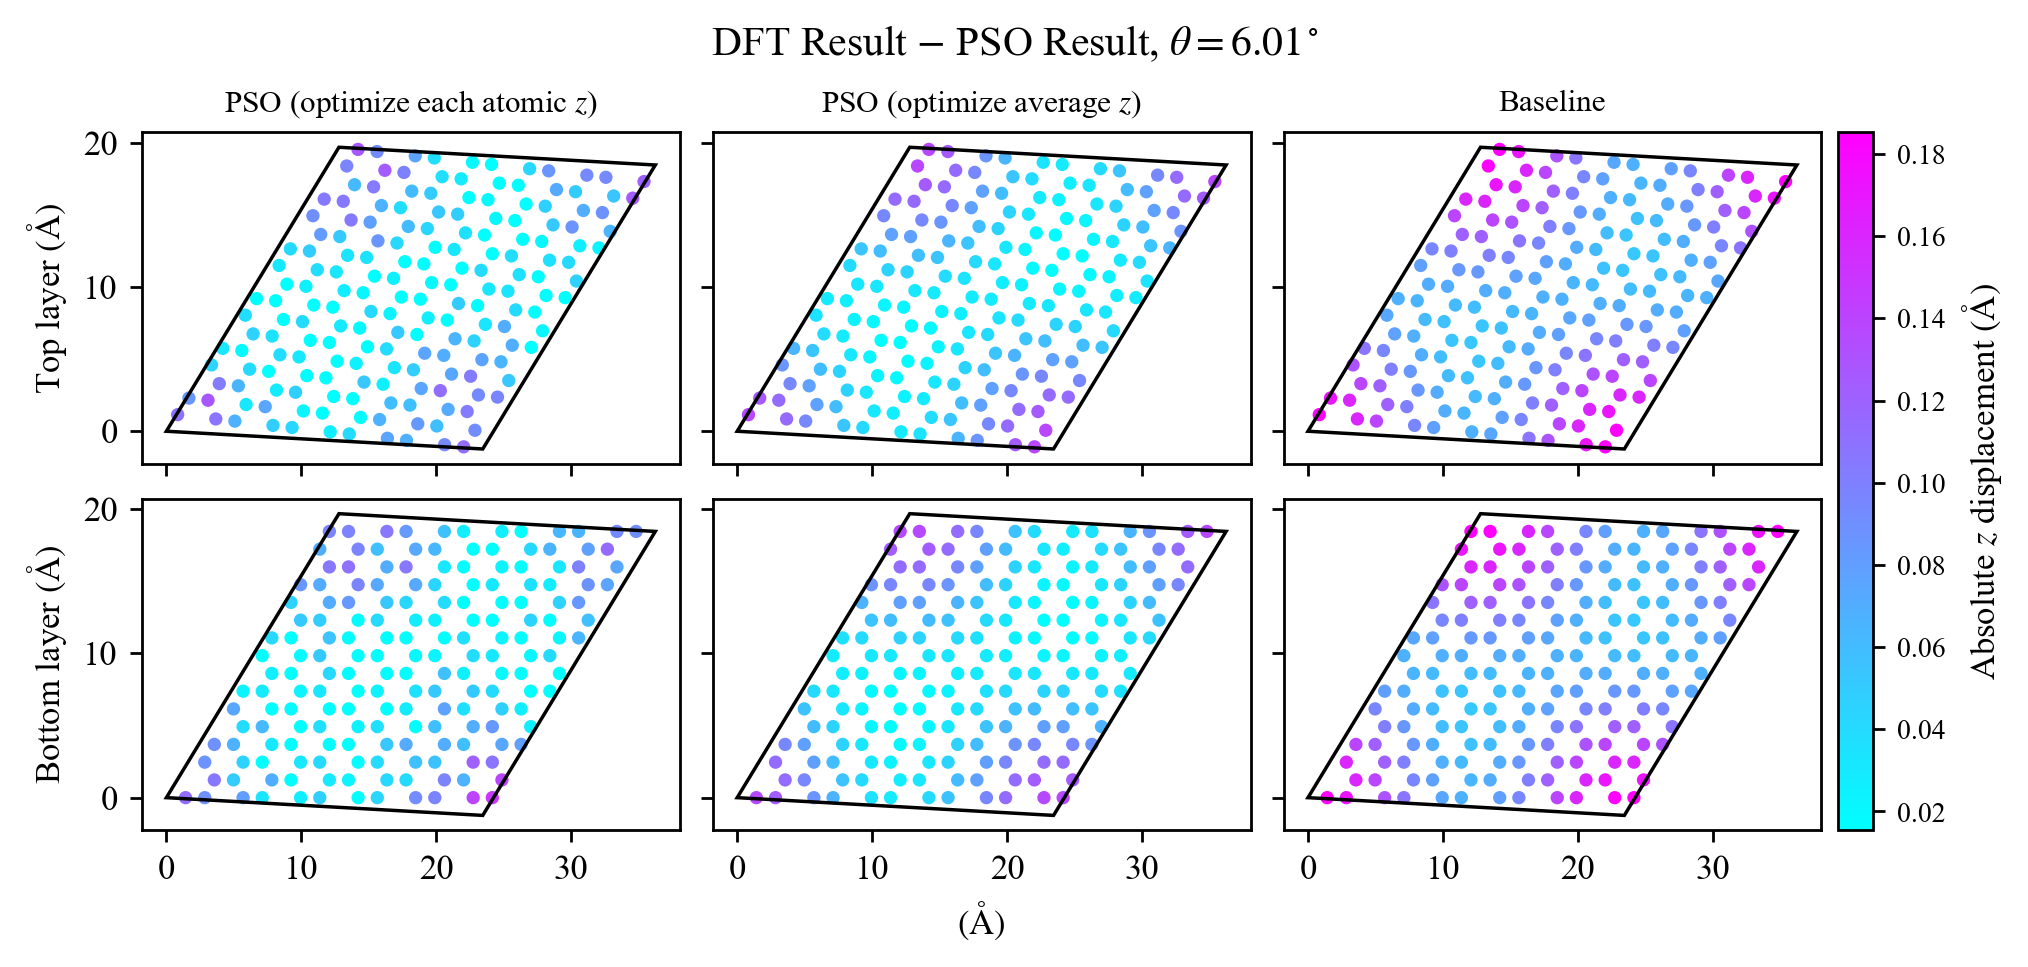

In [55]:
f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 3.5), dpi=250, layout='constrained')
cmap = plt.cm.cool
norm = colors.Normalize(
    vmin=min(
        np.abs(np.amin(pso_z_r[len(pso_z_r) // 2:, 2] - pso_z_u[len(pso_z_u) // 2:, 2])), 
        np.abs(np.amin(pso_2params_r[len(pso_2params_r) // 2:, 2] - pso_2params_u[len(pso_2params_u) // 2:, 2])), 
        np.abs(np.amin(siesta_r[len(siesta_r) // 2:, 2] - siesta_u[len(siesta_u) // 2:, 2])),
        np.abs(np.amin(pso_z_r[:len(pso_z_r) // 2, 2] - pso_z_u[:len(pso_z_u) // 2, 2])), 
        np.abs(np.amin(pso_2params_r[:len(pso_2params_r) // 2, 2] - pso_2params_u[:len(pso_2params_u) // 2, 2])), 
        np.abs(np.amin(siesta_r[:len(siesta_r) // 2, 2] - siesta_u[:len(siesta_u) // 2, 2])),
        # np.amin(pso_u[:len(pso_u) // 2, 2] - pso_r[:len(pso_r) // 2, 2]),
        # np.amin(siesta_u[:len(siesta_u) // 2, 2] - siesta_r[:len(siesta_r) // 2, 2]),
    ), 
    vmax=max(
        np.amax(pso_z_r[len(pso_z_r) // 2:, 2] - pso_z_u[len(pso_z_u) // 2:, 2]), 
        np.amax(pso_2params_r[len(pso_2params_r) // 2:, 2] - pso_2params_u[len(pso_2params_u) // 2:, 2]), 
        np.amax(siesta_r[len(siesta_r) // 2:, 2] - siesta_u[len(siesta_u) // 2:, 2]),
        np.amax(pso_z_r[:len(pso_z_r) // 2, 2] - pso_z_u[:len(pso_z_u) // 2, 2]), 
        np.amax(pso_2params_r[:len(pso_2params_r) // 2, 2] - pso_2params_u[:len(pso_2params_u) // 2, 2]), 
        np.amax(siesta_r[:len(siesta_r) // 2, 2] - siesta_u[:len(siesta_u) // 2, 2]),
        # np.amax(pso_u[:len(pso_u) // 2, 2] - pso_r[:len(pso_r) // 2, 2]),
        # np.amax(siesta_u[:len(siesta_u) // 2, 2] - siesta_r[:len(siesta_r) // 2, 2]),
    ), 
)

origin = pso_z_u[len(pso_z_u) // 2:, :2]
z = pso_z_u[len(pso_z_u) // 2:, 2]
arrow = pso_z_r[len(pso_z_r) // 2:, 2] - z
p1 = axes[0][0].scatter(origin[:, 0], origin[:, 1], c=arrow, cmap=cmap, norm=norm, s=8)
# axes[0].annotate("Top", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
a = siesta_l[0][:2]
b = siesta_l[1][:2]
points = [[0, 0], a, a + b, b]
axes[0][0].add_patch(patches.Polygon(points, fill=False))
axes[0][0].set_title(r"PSO (optimize each atomic $z$)", fontsize=9)
axes[0][0].set_ylabel(r"Top layer $(\mathrm{\AA})$")

origin = pso_2params_u[len(pso_2params_u) // 2:, :2]
z = pso_2params_u[len(pso_2params_u) // 2:, 2]
arrow = pso_2params_r[len(pso_2params_r) // 2:, 2] - z
p2 = axes[0][1].scatter(origin[:, 0], origin[:, 1], c=arrow, cmap=cmap, norm=norm, s=8)
# axes[1].annotate("Bottom", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
a = siesta_l[0][:2]
b = siesta_l[1][:2]
points = [[0, 0], a, a + b, b]
axes[0][1].add_patch(patches.Polygon(points, fill=False))
axes[0][1].set_title(r"PSO (optimize average $z$)", fontsize=9)
# axes[0][1].set_xlabel(r"$\AA$")

origin = siesta_u[len(siesta_u) // 2:, :2]
z = siesta_u[len(siesta_u) // 2:, 2]
arrow = siesta_r[len(siesta_r) // 2:, 2] - z
p3 = axes[0][2].scatter(origin[:, 0], origin[:, 1], c=arrow, cmap=cmap, norm=norm, s=8)
# axes[2].annotate("Top", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
a = siesta_l[0][:2]
b = siesta_l[1][:2]
points = [[0, 0], a, a + b, b]
axes[0][2].add_patch(patches.Polygon(points, fill=False))
axes[0][2].set_title("Baseline", fontsize=9)

origin = pso_z_u[:len(pso_z_u) // 2, :2]
z = pso_z_u[:len(pso_z_u) // 2, 2]
arrow = np.abs(pso_z_r[:len(pso_z_r) // 2, 2] - z)
p1 = axes[1][0].scatter(origin[:, 0], origin[:, 1], c=arrow, cmap=cmap, norm=norm, s=8)
# axes[0].annotate("Top", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
a = siesta_l[0][:2]
b = siesta_l[1][:2]
points = [[0, 0], a, a + b, b]
axes[1][0].add_patch(patches.Polygon(points, fill=False))
# axes[1][0].set_title(r"PSO (optimize each atomic $z$)", fontsize=9)
axes[1][0].set_ylabel(r"Bottom layer $(\mathrm{\AA})$")

origin = pso_2params_u[:len(pso_2params_u) // 2, :2]
z = pso_2params_u[:len(pso_2params_u) // 2, 2]
arrow = np.abs(pso_2params_r[:len(pso_2params_r) // 2, 2] - z)
p2 = axes[1][1].scatter(origin[:, 0], origin[:, 1], c=arrow, cmap=cmap, norm=norm, s=8)
# axes[1].annotate("Bottom", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
a = siesta_l[0][:2]
b = siesta_l[1][:2]
points = [[0, 0], a, a + b, b]
axes[1][1].add_patch(patches.Polygon(points, fill=False))
# axes[1][1].set_title(r"PSO (optimize average $z$)", fontsize=9)
axes[1][1].set_xlabel(r"$(\mathrm{\AA})$")

origin = siesta_u[:len(siesta_u) // 2, :2]
z = siesta_u[:len(siesta_u) // 2, 2]
arrow = np.abs(siesta_r[:len(siesta_r) // 2, 2] - z)
p3 = axes[1][2].scatter(origin[:, 0], origin[:, 1], c=arrow, cmap=cmap, norm=norm, s=8)
# axes[2].annotate("Top", xy=(0.75, 0.15), xycoords="axes fraction", fontsize=8, color="k")
# Parallelogram
a = siesta_l[0][:2]
b = siesta_l[1][:2]
points = [[0, 0], a, a + b, b]
axes[1][2].add_patch(patches.Polygon(points, fill=False))
# axes[1][2].set_title("Baseline", fontsize=9)

# Create a single colorbar for all subplots
cbar = f.colorbar(
    p3, 
    ax=axes.ravel().tolist(), 
    label=r"Absolute $z$ displacement $(\mathrm{\AA})$",
    pad=0.01
    # ticks=[0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
)
# cbar.ax.set_yticklabels([0.06, "", 0.08, "", 0.1, "", 0.12, "", 0.14, ""], fontsize=8)

# Set smaller font size for the colorbar tick marks
cbar.ax.tick_params(labelsize=8)

plt.suptitle(fr"DFT Result $-$ PSO Result, $\theta={np.round(angles(N), 2)}^\circ$", y=1.06, fontsize=12)
# plt.savefig("test-relaxation.png", bbox_inches="tight", dpi=200)
# plt.savefig(f"relaxation-comparisons/N_{N}_relaxation-z_comparison.png", bbox_inches="tight", dpi=250)

In [34]:
def count_word_and_last_word_in_clock_files(base_folder, word):
    """
    Count the occurrences of a word and get the last word of the last line in files named 'CLOCK'.

    Parameters:
        base_folder (str): The base directory to start searching for files.
        word (str): The word to count in the files.
    """
    counts = []
    times = []
    # Walk through all directories in the base_folder
    for root, dirs, files in os.walk(base_folder):
        if 'CLOCK' in files:
            # Construct the file path
            file_path = os.path.normpath(os.path.join(root, 'CLOCK'))
            
            try:
                # Read the file and count occurrences
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    count = content.count(word)
                
                # Find the last word of the last line
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()
                    if lines:  # Check if the file is not empty
                        last_line = lines[-1].strip()
                        last_word = last_line.split()[-1] if last_line else "(no last word)"
                    else:
                        last_word = "(empty file)"
                
                # Print results
                print(f"File: {file_path}, Word: '{word}', Count: {count}, Last Word: '{last_word}'")
                counts.append(int(count))
                times.append(float(last_word))
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    return counts, times

# Example usage
counts, times = [], []
for N in [4, 5, 6, 7, 8, 9]:
    base_folder = fr"C:\Users\alber\AM207-final-project\N_{N}"  # Replace with your folder path
    word_to_search = "geometry"  # Replace with the word you want to count
    count, time = count_word_and_last_word_in_clock_files(base_folder, word_to_search)
    if N == 4:
        count = count[::2]
        time = time[::2]
    counts.append(count)
    times.append(time)
counts = np.array(counts)
times = np.array(times)

File: C:\Users\alber\AM207-final-project\N_4\DFT-structures\CLOCK, Word: 'geometry', Count: 29, Last Word: '415.622'
File: C:\Users\alber\AM207-final-project\N_4\DFT-structures\unrelaxed\CLOCK, Word: 'geometry', Count: 1, Last Word: '26.190'
File: C:\Users\alber\AM207-final-project\N_4\PSO-2params\CLOCK, Word: 'geometry', Count: 27, Last Word: '423.897'
File: C:\Users\alber\AM207-final-project\N_4\PSO-2params\unrelaxed\CLOCK, Word: 'geometry', Count: 1, Last Word: '21.485'
File: C:\Users\alber\AM207-final-project\N_4\PSO_z\CLOCK, Word: 'geometry', Count: 69, Last Word: '905.139'
File: C:\Users\alber\AM207-final-project\N_4\PSO_z\unrelaxed\CLOCK, Word: 'geometry', Count: 1, Last Word: '39.317'
File: C:\Users\alber\AM207-final-project\N_5\DFT-structures\CLOCK, Word: 'geometry', Count: 31, Last Word: '808.834'
File: C:\Users\alber\AM207-final-project\N_5\PSO-2params\CLOCK, Word: 'geometry', Count: 31, Last Word: '753.205'
File: C:\Users\alber\AM207-final-project\N_5\PSO_z\CLOCK, Word: 'ge

In [35]:
counts

array([[29, 27, 69],
       [31, 31, 77],
       [42, 38, 79],
       [40, 38, 79],
       [46, 39, 66],
       [46, 42, 85]])

In [36]:
times

array([[  415.622,   423.897,   905.139],
       [  808.834,   753.205,  1808.987],
       [ 1796.092,  1599.692,  3258.434],
       [ 2140.456,  1942.587,  4364.032],
       [ 3662.95 ,  3161.308,  5433.987],
       [ 5956.679,  5027.239, 11178.819]])

In [37]:
x = np.arange(4, 10, 1, dtype=int)
x = [angles(xi) for xi in x]

C:\Users\alber\AppData\Local\Temp\ipykernel_115824\1515130831.py:48: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # Adjust layout to avoid overlap


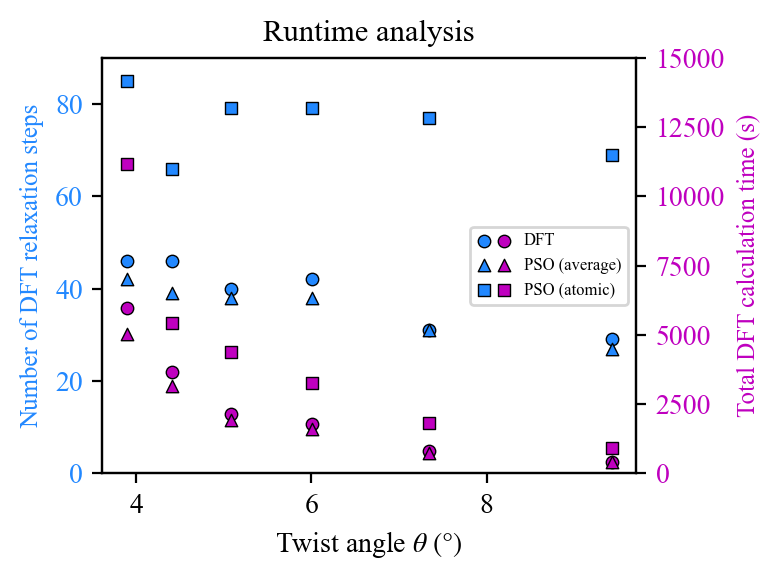

In [48]:
from matplotlib.legend_handler import HandlerTuple

legend = []

# Create the plot
fig, ax1 = plt.subplots(1, 1, figsize=(4, 3), layout="constrained", dpi=200)

# Plot the first dataset
dft_1 = ax1.scatter(x, counts[:, 0], label='DFT', color="#2288FF", s=20, edgecolor="k", lw=0.5)
ax1.tick_params(axis='y', labelcolor="#2288FF")

# Create a twin y-axis sharing the same x-axis
ax2 = ax1.twinx()
dft_2 = ax2.scatter(x, times[:, 0], label='DFT', color="m", s=20, edgecolor="k", lw=0.5)
ax2.tick_params(axis='y', labelcolor='m')

# Plot the first dataset
pso_z_1 = ax1.scatter(x, counts[:, 1], label='PSO (atomic)', color="#2288FF", s=20, marker="^", edgecolor="k", lw=0.5)
ax1.tick_params(axis='y', labelcolor="#2288FF")

# Create a twin y-axis sharing the same x-axis
pso_z_2 = ax2.scatter(x, times[:, 1], label='PSO (atomic)', color="m", marker="^", s=20, edgecolor="k", lw=0.5)
ax2.tick_params(axis='y', labelcolor='m')

# Plot the first dataset
pso_2params_1 = ax1.scatter(x, counts[:, 2], label='PSO (average)', color="#2288FF", s=20, marker="s", edgecolor="k", lw=0.5)
ax1.set_xlabel(r'Twist angle $\theta$ $(\degree)$')
ax1.set_ylabel('Number of DFT relaxation steps', color="#2288FF", fontsize=9)
ax1.tick_params(axis='y', labelcolor="#2288FF")

# Create a twin y-axis sharing the same x-axis
pso_2params_2 = ax2.scatter(x, times[:, 2], label='PSO (average)', color="m", marker="s", s=20, edgecolor="k", lw=0.5)
ax2.set_ylabel('Total DFT calculation time (s)', color='m', fontsize=9)
ax2.tick_params(axis='y', labelcolor='m')

ax1.set_ylim(0, 90)
ax2.set_ylim(0, 15000)
ax1.set_title("Runtime analysis", fontsize=11)
ax1.legend(
    [(dft_1, dft_2), (pso_z_1, pso_z_2), (pso_2params_1, pso_2params_2)], 
    ["DFT", fr"PSO (average)", "PSO (atomic)"], 
    handler_map={tuple: HandlerTuple(ndivide=None)}, 
    fontsize=6, 
    loc="center right"
)

# Add legends
fig.tight_layout()  # Adjust layout to avoid overlap
plt.savefig("runtime-test.png", bbox_inches="tight", dpi=200)

In [41]:
forces_DFT = np.loadtxt("N_4/DFT-structures/unrelaxed/Graphene.FA", skiprows=1, usecols=[1, 2, 3]).flatten()
forces_PSO_z = np.loadtxt("N_4/PSO_z/unrelaxed/Graphene.FA", skiprows=1, usecols=[1, 2, 3]).flatten()
forces_PSO_2params = np.loadtxt("N_4/PSO-2params/unrelaxed/Graphene.FA", skiprows=1, usecols=[1, 2, 3]).flatten()

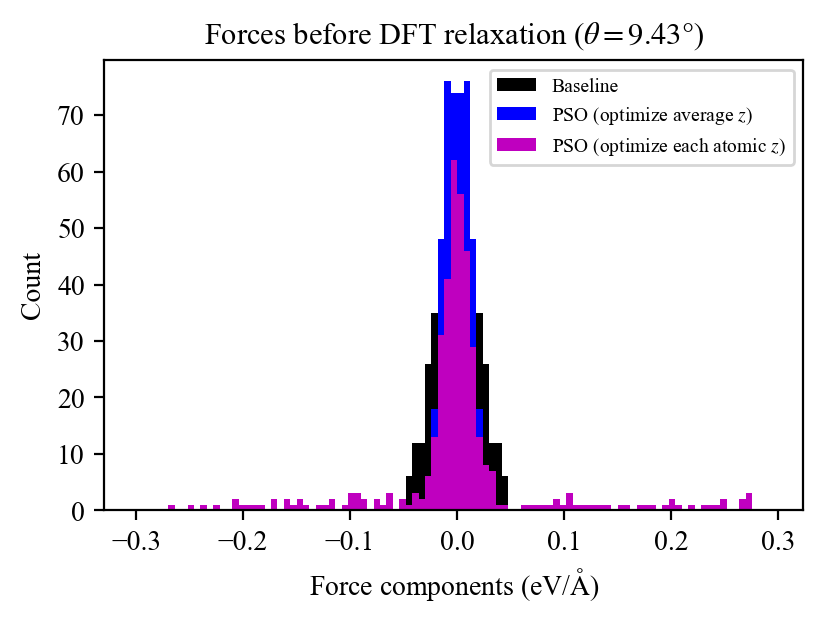

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), layout="constrained", dpi=200)
bins = np.arange(-0.3, 0.3, 0.006)
ax.hist(forces_DFT, bins=bins, alpha=1, color="k", label=r"Baseline")
ax.hist(forces_PSO_2params, bins=bins, alpha=1, color="b", label=r"PSO (optimize average $z$)")
ax.hist(forces_PSO_z, bins=bins, alpha=1, color="m", label=r"PSO (optimize each atomic $z$)")
ax.legend(fontsize=7)
ax.set_ylabel("Count")
ax.set_xlabel(r"Force components (eV/$\mathrm{\AA}$)")
ax.set_title(fr"Forces before DFT relaxation ($\theta={np.round(angles(4), 2)}\degree$)", fontsize=11)
# plt.savefig("forces-test.png", bbox_inches="tight", dpi=200)